In [ ]:
# installing required libraries

!pip install transformers[torch]
!pip install datasets
!pip install sentence_transformers
!pip install numba



In [2]:
# importing them

import pandas as pd
import numpy as np
from numba import cuda
from transformers import create_optimizer
import gc
from transformers import get_scheduler
from torch.optim import AdamW
import torch.cuda
from google.colab import runtime
import torch
import numpy as np
import pandas as pd
from datasets import Dataset, load_metric
import io
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


---


**notes: add a summary describing the datset and the problem (what is written in the paper)**

---

## Preprocessing

In [3]:
dc = pd.read_excel('/content/DecOp_data_EN_500.xlsx', header=0)

dc.head()



d1 = []
for i in range(dc.shape[0]):
  row = dc.iloc[i]
  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['A'].replace('\n', " ") ,
  'labels'  : row['GT.A']})

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['E'].replace('\n', " ")  ,
  'labels'  : row['GT.E']})
  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['GM'].replace('\n', " ")  ,
  'labels'  : row['GT.GM']})

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['Pom'].replace('\n', " ")  ,
  'labels'  : row['GT.Pom']})

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['CL'].replace('\n', " ")  ,
  'labels'  : row['GT.CL']})

decop = pd.DataFrame.from_records(d1)

decop=decop[['ID', 'sent', 'labels']]
decop['type']='A'
decop['labels'] = decop['labels'].apply(lambda x: 0 if x == 'F' else 1)


In [4]:
decop[:5]

,ID,sent,labels,type
0,1,Abortion should be banned! People are killing ...,0,A
1,1,I'm assuming we're talking about animals... eu...,1,A
2,1,I think gay marriage is just a normal as strai...,1,A
3,1,We need to keep them out of the country. They ...,0,A
4,1,I think it should be legalized and regulated l...,1,A


In [5]:
def create_dataset(Scenario={'train': [], 'test': [], 'scenario': 1}, decop=None, seed=42, cv=10):

    # generate training and testing set based on Scenario dictionary
    # cv number of cross-validation

    # initialize dictionaries to store train and test dataset for each split
    train = {f'split_{i + 1}': [] for i in range(cv)}
    test = {f'split_{i + 1}': [] for i in range(cv)}

    # generate shuffled indices for data splits
    np.random.seed(seed)

    de_arr = np.arange(1, 501)
    np.random.shuffle(de_arr)
    de_arr_r = de_arr.reshape((cv, int(500 / cv)))

    # generate train/test split
    # iterates over the splits and based on the scenario create train and test set.

    cv_ind = 0
    for k in train.keys():

        if Scenario['scenario'] == 1:

            if 'decop' in Scenario['train']:
                ind = de_arr_r[cv_ind, :]
                antind = [i for i in de_arr if i not in ind]

                decop_train = decop[decop['ID'].isin(antind)]
                decop_test = decop[decop['ID'].isin(ind)]

                train[k].append(decop_train)
                test[k].append(decop_test)

            train[k] = pd.concat(train[k])
            test[k] = pd.concat(test[k])

        cv_ind += 1

    return train, test


# GPT2 Model

GPT have only the decoder side of the Transformer, which are stacked on top of each other. Depending on the number of decoder blocks there are different variations of GPT2. The model dimensionality increases with the number of decoder blocks that we stack


---


**notes: check info about GPT3.5 or GPT4**

---


 In other words, the model dimensionality means how many tokens (how many words) can you fed into the model. With a small model you can fed 768 tokens and with extra-large model we can fed 1600.


---


**notes: do a diagram of how GPT3 works**


---


*how can we use GPT for simply text classification task?*
From bottom to top, we have our input (row text), that is splitted into words, we fed it into GPT model that is going to output the word embeddings for each of those words, and we grab the last word embedding, thats the one that hase the highest information, we fed it into a classification layer. For this task, we ask the model what should be the sentiment that is associated to this input.


The preprocessing takes care of all the tensor conversion, encoding, padding, and data formatting needed to convert the raw text data into the numerical inputs that the GPT-2 model requires for either training or inference.

1. Rather than accepting raw text as input, the transformer-based language model GPT-2 expects numeric tensor inputs. In order to feed the raw text into the model, we must turn it into numerical tensors. Tokenizer is used for this.

2. To ensure that every input is a consistent length for batching, the tokenizer encodes each text sequence into a number and manages padding and truncation to a maximum length. Performance and efficiency both benefit from this.
3. In order to send the labels into the loss function during training, they too must be transformed from a list into a tensor. The label tensor represents the next token that the model is taught to predict.


In [6]:
def preprocess_function_gpt2(examples):
    # Get all texts from sequences list and convert to lowercase.
    texts = [ex.lower() for ex in examples["sent"]]
    # Get all labels from sequences list.
    labels = [ex for ex in examples["labels"]]
    # Call tokenizer on all texts to convert into tensors of numbers with
    # appropriate padding.
    inputs = tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True)
    # Update the inputs with the associated encoded labels as tensor.
    inputs.update({'labels': torch.tensor(labels)})
    return inputs

The model, tokenizer, configuration, weights, padding, and devices are all properly initialized throughout this configuration and loading phase to guarantee correct setup prior to training.

Set the initial model configuration. The GPT-2 config specifies the model architecture's critical hyperparameters and settings, such as the number of layers, attention heads, vocabulary size, etc. For our pre-trained model, we must initialize this correctly.
Load tokenizer: The tokenizer is in charge of translating text to the numerical tokens needed by the model. Tokenizer loading is required in order for the pre-trained weights to match.
Padding token configurations: We have set the padding to be equal to the EOS token and to be left. This manages padding uniformly during batching.
Load actual model weights: HuggingFace provides the pre-trained GPT-2 model weights. This avoids starting from scratch by utilizing transfer learning.
Resize embeddings: To align the model's token embeddings matrix with the tokenizer's vocabulary scale, we resize it.
Set pad token id: We configure the model's padding token id to correspond with the tokenizer's pad token id. An additional important alignment step.
To effectively utilize hardware acceleration, we forward the model to a designated device (CPU/GPU).

For the purpose of text categorization, this script optimizes a GPT-2 model and assesses performance using k-fold cross validation. An outline of its main functions is provided below:

General goal and design:

Optimize GPT-2 transformer for text categorization
Run a 10-fold cross-validation.
To understand the behavior of the model, assess accuracy over ten times.

Important phases

1. Import information.

Utilizing a customized data loading mechanism, creates train and test splits.

2. Fine-tuning loop
Every fold:
Preprocess divides into PyTorch datasets with encoding

Create a Trainer instance to adjust the loaded GPT-2.

Model optimization is configured via TrainingArguments.

Train model on the train divide of this fold

Based on this fold's test split, evaluate

Record measures such as precision.

3. Analysis

Combine forecasts and accuracy across folds

Print comprehensive performance data.

Examine model behavior, including accuracy for min/max/stddev.





---

** Something we can add, that is usually done when fine-tuning GPT2**

**note: we can also test this**

total_steps = len(data_train) * params['num_train_epochs']

scheduler = get_linear_schedule_with_warmup(optimizer,
                                                        num_warmup_steps=0,
                                                        num_training_steps=total_steps)

                                                

---

here we also store the errors to do further analysis on the examples that the model makes them. The results are stored here: errors_df .

**note: I have no idea how we are supposed to make further analysis to explain why the model made that error. ASK THE PROF.**

In [7]:
from datasets import Dataset, load_metric

In [11]:
# Set seed for reproducibility.
seed = (42)
np.random.seed(seed)
collect_result = {}
num_labels = 2
epochs = 2
# this value is 2 just to test that it works'should be 10 numcv
numcv = 10
model_name_or_path = 'gpt2'
n_labels = 2
dataset = ['decop']
Scenario = {'train': dataset, 'test': dataset, 'scenario': 1}
results = {}
types = {}
preds = {}
trus = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train, test = create_dataset(Scenario, decop=decop, seed=seed, cv=numcv)

# Define hyperparameters for grid search

#param_grid = {
#    'per_device_train_batch_size': [2,4,8],
#   'learning_rate': [3e-5],
#    'weight_decay': [0.01,0.001, 0.0001],
    # Add more hyperparameters as needed
#}

param_grid = {
    'per_device_train_batch_size': [2],
    'learning_rate': [2e-5],
    'weight_decay': [0.01],
    # Add more hyperparameters as needed
}

for params in tqdm(list(ParameterGrid(param_grid))):

  for sp in tqdm(train.keys()):

    data_train = Dataset.from_pandas(train[sp])
    data_test = Dataset.from_pandas(test[sp])
    model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
    model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
    tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
    tokenizer.padding_side = "left"
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id
    model.resize_token_embeddings(len(tokenizer))



    data_train = data_train.map(preprocess_function_gpt2, batched=True)
    data_test = data_test.map(preprocess_function_gpt2, batched=True)


    training_args = TrainingArguments(
    output_dir=f"gpt2-finetuned-textclass_fold_batch{params['per_device_train_batch_size']}_lr{params['learning_rate']}_wd{params['weight_decay']}",
    evaluation_strategy="epoch",
    num_train_epochs=epochs,
    per_device_train_batch_size=params['per_device_train_batch_size'],
    learning_rate=params['learning_rate'],
    lr_scheduler_type="linear",
    weight_decay=params['weight_decay'],
    save_total_limit=3,
    seed=42,
    fp16=True, # if u run in CPU this parameter needs ot be commented, works only for GPU
    push_to_hub=False,
    warmup_steps=500
    )
    optimizer = AdamW(model.parameters(),
                              lr=params['learning_rate'],
                              eps=1e-8
                              )
    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_train,
    eval_dataset=data_test,
    tokenizer=tokenizer,
    optimizers=(optimizer, None) # Ninstead of none we can add scheduler - after defining it
    )

    trainer.train()
    pred = []
    for i in test[sp]['sent']:
      inputs = tokenizer(i, padding=True, truncation=True, return_tensors="pt").input_ids
      with torch.no_grad():
        logits = model(inputs.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))[0]
        label = logits.argmax(-1).item()
        pred.append(label)

    pred = np.array(pred)

    types[sp] = data_test['type']
    preds[sp] = pred
    trus[sp] = np.array(test[sp]['labels'])

    errors_df = pd.DataFrame({"Text": test[sp]['sent'],
                              "True_Label": trus[sp],
                              "Predicted_Label": pred})
    errors_df.to_csv(f"error_analysis_{sp}.csv", index=False)

    collect_result[sp]=pd.DataFrame.from_dict({"prediction": pred, 'labels': np.array(test[sp]['labels']), 'type': test[sp]['type']})
    collect_result[sp]['corr'] = collect_result[sp]['prediction'] == collect_result[sp]['labels']
    results[sp] = [(pred == trus[sp]).mean()]
    del model
    del trainer
    torch.cuda.empty_cache()

results = pd.DataFrame.from_dict(results)
print('Average accuracy: ', results.mean(axis=1))
print('Standard deviation of accuracy: ', results.std(axis=1))
print('Max accuracy: ', results.max(axis=1))
print('Min deviation of accuracy: ', results.min(axis=1))
show_result = pd.concat(collect_result.values(), keys=collect_result.keys())
show_result = show_result.droplevel(1)

print("Average accuracy typewise")
display(show_result.groupby([show_result.index, 'type']).mean().groupby('type')['corr'].mean())
print("Standard deviation of accuracy typewise")
display(show_result.groupby([show_result.index, 'type']).mean().groupby('type')['corr'].std())
print("Max accuracy typewise")
display(show_result.groupby([show_result.index, 'type']).mean().groupby('type')['corr'].max())
print("Min accuracy typewise")
display(show_result.groupby([show_result.index, 'type']).mean().groupby('type')['corr'].min())


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.760300,0.622949
2,1.000000,1.329533


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.758000,1.025711
2,0.838900,1.268409


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.805000,0.661075
2,0.881400,0.892059


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.002900,0.694247
2,0.985100,1.107452


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.747400,1.815927
2,0.927800,1.568766


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.780800,0.840600
2,0.987000,0.890421


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.799300,1.025714
2,1.031900,1.300121


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.769300,0.831880
2,0.954100,0.988846


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.837400,1.335516
2,0.895500,1.259741


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.773300,0.710850
2,0.939300,1.322244


Average accuracy:  0    0.5808
dtype: float64
Standard deviation of accuracy:  0    0.057621
dtype: float64
Max accuracy:  0    0.668
dtype: float64
Min deviation of accuracy:  0    0.472
dtype: float64
Average accuracy typewise


type
A    0.5808
Name: corr, dtype: float64

Standard deviation of accuracy typewise


type
A    0.057621
Name: corr, dtype: float64

Max accuracy typewise


type
A    0.668
Name: corr, dtype: float64

Min accuracy typewise


type
A    0.472
Name: corr, dtype: float64




















































































---


**note: we show the prof what we have done with GPT2. We still can use this model and make a comparison between GPT3.5 and GPT2. Based on his feedback we change things**

**important note: hopefully the structure of GPT3.5 will be the same!!! I'm prety sure that the way that the tokenization is done would be pretty the same..maybe we just need to add API call to use the model.**


---





---

here you can find detailed information about how to fine-tune GPT2 for text classification: https://www.youtube.com/watch?v=Ck9-0YkJD_Q&ab_channel=AICamp

This is for you to undesrtand better what we are doing, even that I have added the necessary information (also partially taken from this video). The way the training and evaluation is done corresponds to the way that the prof does this in the notebook: https://github.com/robecoder/VerbalLieDetectionWithLLM/blob/main/LieDetection/CVexpSc1Decop.ipynb

Feel free to add comments!!

Steps to take:
1. We ask the prof why he is doing seq2seq model when it is sequence classification?
2. we show the way we use GPT2
3. we ask if we need to join to the wait list of GPT4 or is it ok to go with GPT3.5
4. we propose the idea to compare GPT2 with GPT3.5 model


Steps we can already do:

1. add a summary describing the datset and the problem (what is written in the paper)
2. describing with a detailed diagram how GPT2 nand GPT3.5 or(GPT4) works
3. Run again the notebook (have opened a third google account bcs I have finished GPU), to have and understand what kind of results we get -

We thought to run 9 combinations each, using different learning rates (store the results somewhere, bcs when google disconects it deletes them :p ):
[
Mario: 1e-5,
Chelsie: 2e-5,
Rovena: 3e-5
]
---



## GPT3.5 API


In [ ]:
from datasets import Dataset, load_metric
import json

Here I'm not transforming T, F to 0 and 1

In [ ]:
dc = pd.read_excel('/content/DecOp_data_EN_500.xlsx', header=0)

dc.head()



d1 = []
for i in range(dc.shape[0]):
  row = dc.iloc[i]
  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['A'].replace('\n', " ") ,
  'labels'  : row['GT.A']})

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['E'].replace('\n', " ")  ,
  'labels'  : row['GT.E']})
  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['GM'].replace('\n', " ")  ,
  'labels'  : row['GT.GM']})

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['Pom'].replace('\n', " ")  ,
  'labels'  : row['GT.Pom']})

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['CL'].replace('\n', " ")  ,
  'labels'  : row['GT.CL']})

decop = pd.DataFrame.from_records(d1)

decop=decop[['ID', 'sent', 'labels']]
decop['type']='A'

In [ ]:
def create_jsonl(dataset: pd.DataFrame, file_name: str) -> None:
    with open(f'{file_name}.jsonl', 'w') as file:
        for row in dataset.itertuples():
            file.write(json.dumps({"prompt": row.sent, 'completion': row.labels})+'\n')
    file.close()

In [ ]:
pip install openai==0.28

In [ ]:
import openai
from collections import defaultdict
import numpy as np
# ask me for the key
openai.api_key = "[]"

In [ ]:
# Set seed for reproducibility.
seed = (42)
np.random.seed(seed)
collect_result = {}
num_labels = 2
numcv = 10
n_labels = 2
dataset = ['decop']
Scenario = {'train': dataset, 'test': dataset, 'scenario': 1}
results = {}
types = {}
preds = {}
trus = {}

training_file_name = "training"
validation_file_name = "testing"
train, test = create_dataset(Scenario, decop=decop, seed=seed, cv=numcv)

for sp in tqdm(train.keys()):

    data_train = train[sp]
    data_test = test[sp]
    create_jsonl(data_train, "training")
    create_jsonl(data_test, "testing")
    training_file = openai.File.create(
        file = open("training.jsonl","rb"),
         purpose = "fine-tune"
    )

    testing_file = openai.File.create(
        file = open("testing.jsonl","rb"),
         purpose = "fine-tune"
    )

    training_file_id = training_file["id"]
    testing_file_id = testing_file["id"]

    fine_tuning_job = openai.FineTuningJob.create(
                                                 training_file = training_file_id,
                                                 validation_file = testing_file_id,
                                                  model="davinci-002"
                                                   )

In [ ]:
job_id = fine_tuning_job['id']

In [ ]:
response = openai.FineTuningJob.retrieve(job_id)
response


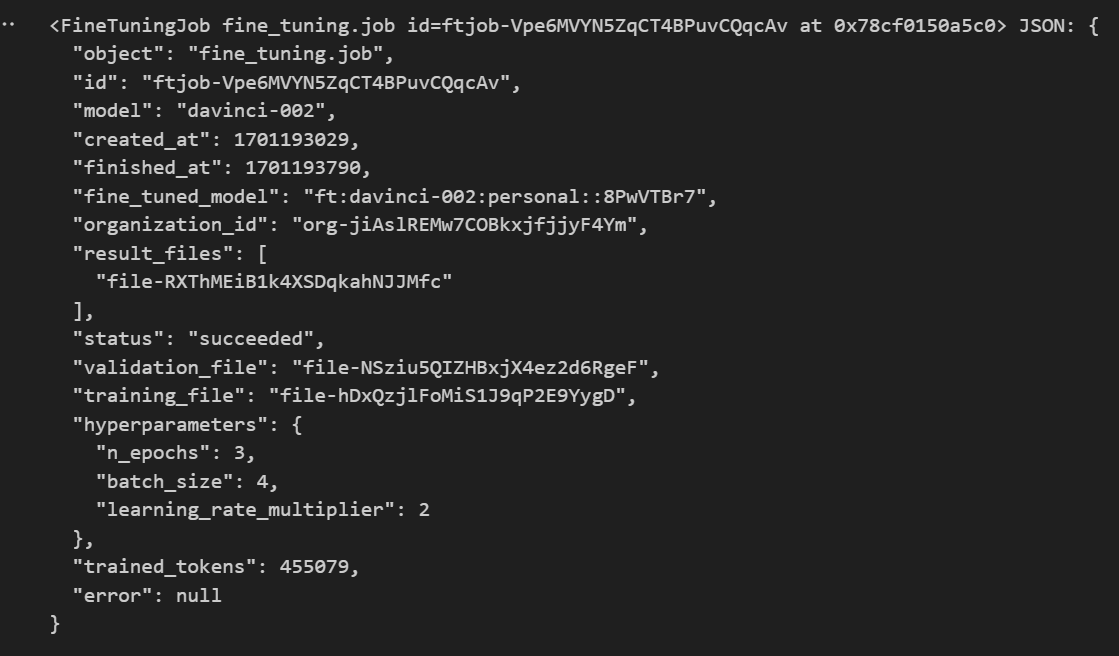

In [ ]:
response = openai.FineTuningJob.list_events(id=job_id, limit=10)
response

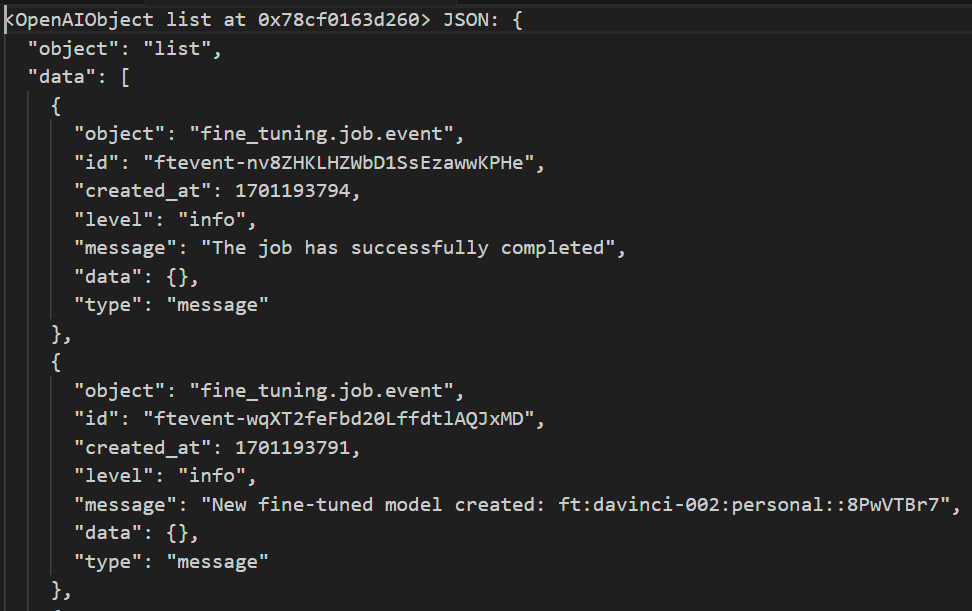

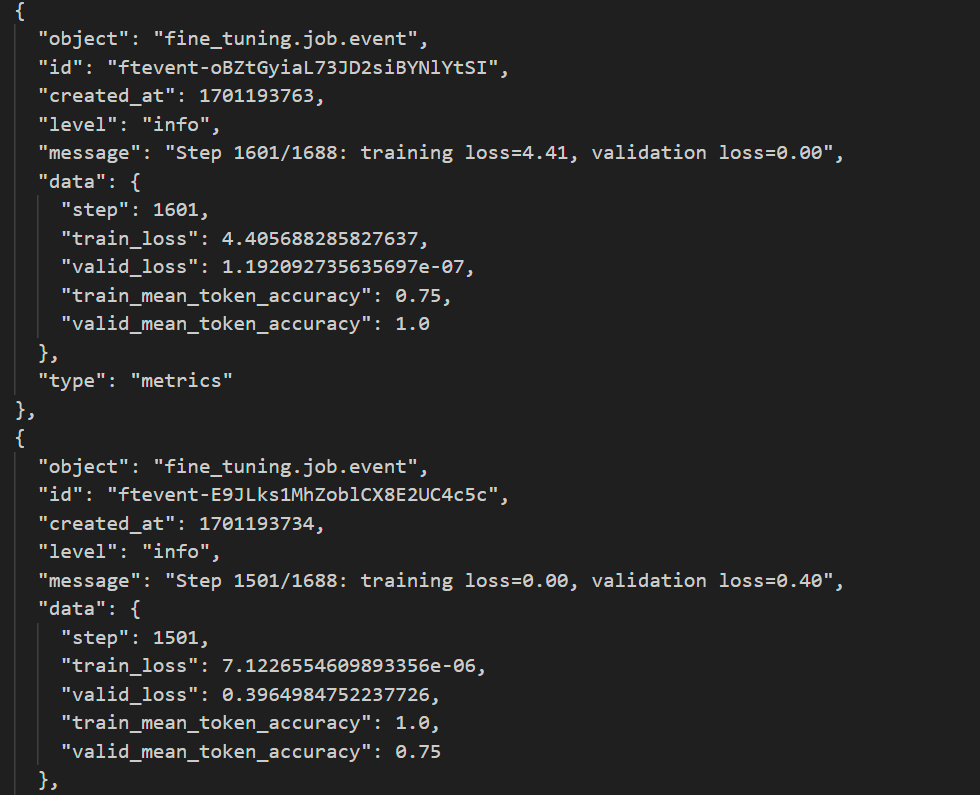

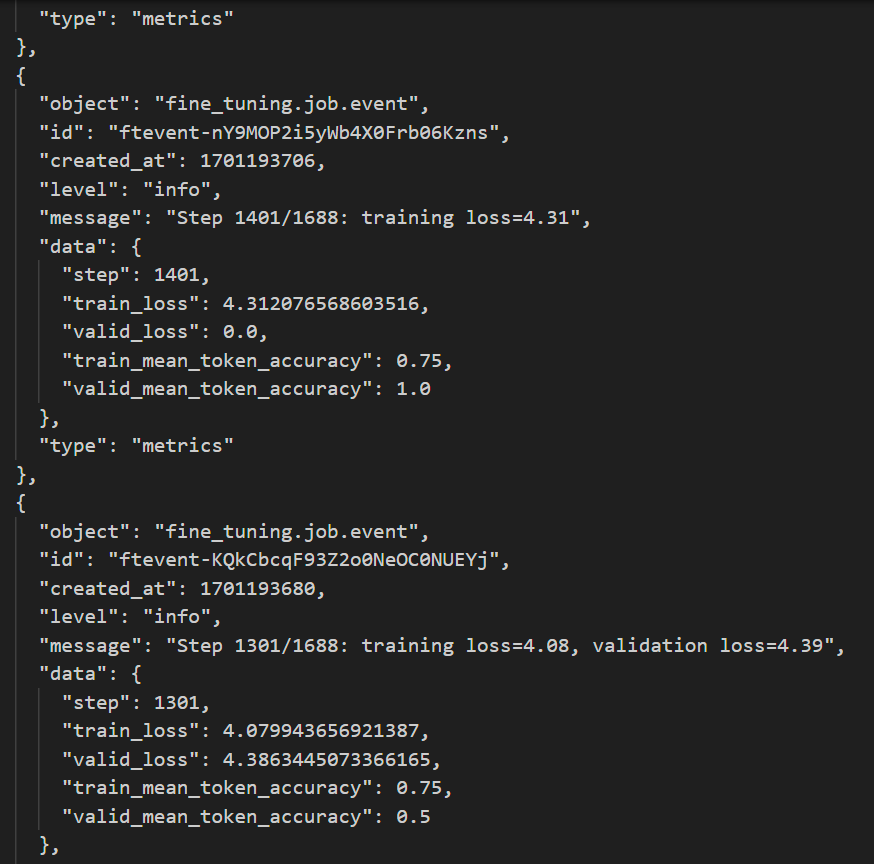

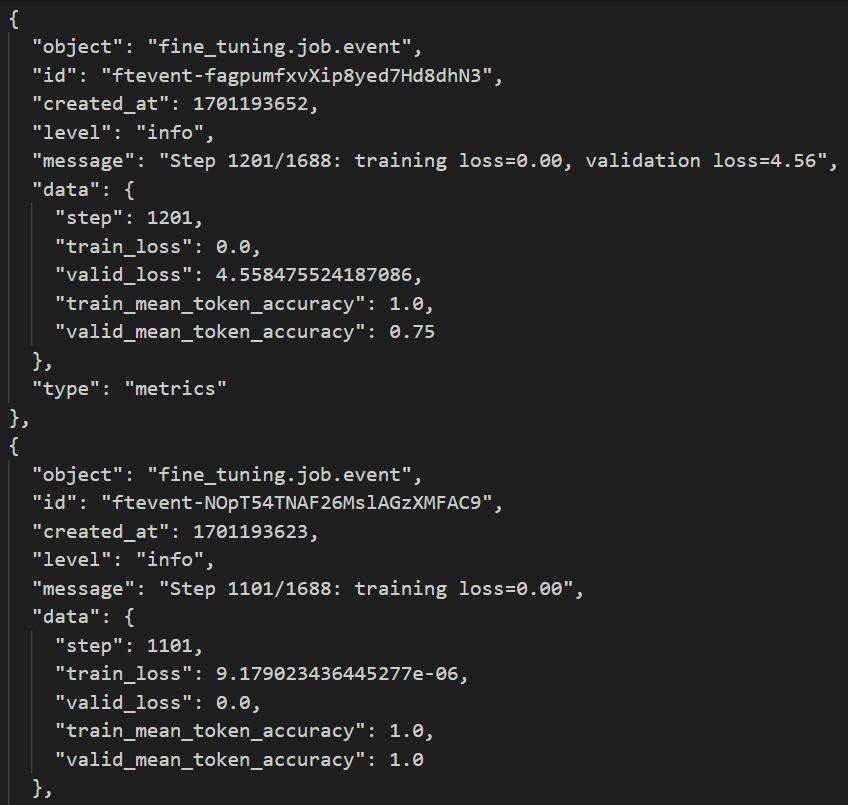

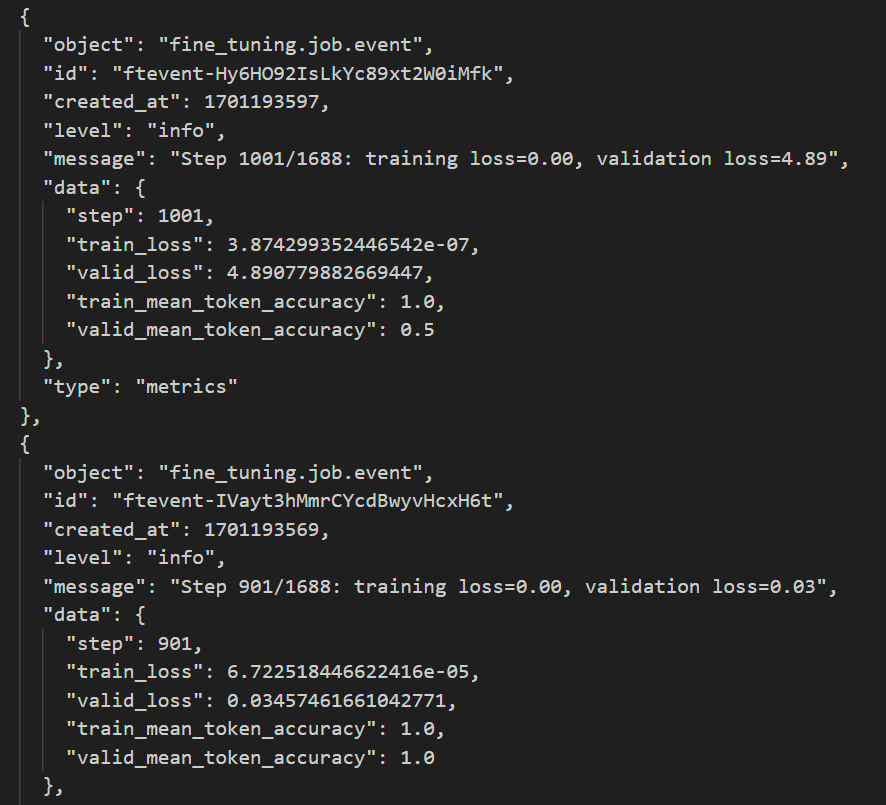

In [ ]:
events = response["data"]
events.reverse()

for event in events:
    print(event["message"])

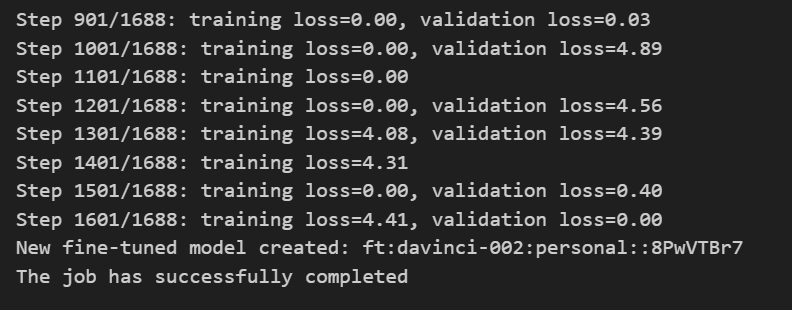